# import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta
import random
import torch
import torch.backends.cudnn  as cudnn


# Set seed

In [2]:


seed = 42
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)



# Download Input

In [3]:
import os
import glob
import pandas as pd

# Define the path to the main folder
main_folder_path = 'AAPL_data'
ticker = "AAPL"
# Use glob to get a list of CSV files from all subfolders
csv_files = glob.glob(os.path.join(main_folder_path, '*', '*.csv'))

# List to hold all the DataFrames
all_stock_data_list = []
label_list = []
all_pct_list = []
# Loop over the list of csv files
for file in csv_files:
    # Read the csv file and append it to the list of DataFrames
    if 'result' not in file:
        df = pd.read_csv(file,index_col='Date', parse_dates=True)
        df['pct_change'] = df['Close'].pct_change()
        df.dropna(inplace=True)
        label_list.append(df['Label'])
        all_pct_list.append(df['pct_change'].tolist())
        df.drop(columns=['pct_change'], inplace=True)
        all_stock_data_list.append(df)
    else:
        csv_files.remove(file)
    


# Data Preprocessing

In [4]:
stock = all_stock_data_list[0]
labels = label_list[0]
close_pct_change = all_pct_list[0]
all_date = stock.index
stock.dropna(inplace=True)

# Create Sequence and Dataloader for K Fold LSTM

In [5]:

def create_sequences(data, labels, pct_change, all_date, seq_length):
    xs = []
    ys = []
    pct_list = []
    date_list = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = labels[i+seq_length]
        pct = pct_change[i+seq_length]
        date = all_date[i+seq_length]
        xs.append(x)
        ys.append(y)
        pct_list.append(pct)
        date_list.append(date)
    return np.array(xs), np.array(ys), np.array(pct_list), np.array(date_list)



In [6]:
from sklearn.model_selection import KFold

# Define the number of splits for K-Fold
def  kfold_data(X_all, y_all, pct_list, date_list, n_splits=10):

    # Create the KFold object with the specified number of splits
    kf = KFold(n_splits=n_splits)

    # Initialize lists to hold the fold data
    X_train_folds = []
    y_train_folds = []
    X_val_folds = []
    y_val_folds = []
    pct_train_folds = []
    pct_val_folds = []
    date_val_fold = []
    # Generate the indices for the K-Fold
    kf_indices = kf.split(X_all[0:len(X_all)])

    # Loop through each fold
    for train_index, val_index in kf_indices:
        # Generate the training and validation sets for X and y
        X_train, X_val = X_all[train_index], X_all[val_index]
        y_train, y_val = y_all[train_index], y_all[val_index]
        pct_train, pct_val = pct_list[train_index], pct_list[val_index]
        date_val = date_list[val_index]
        # Append the data for this fold to the lists
        X_train_folds.append(X_train)
        y_train_folds.append(y_train)
        X_val_folds.append(X_val)
        y_val_folds.append(y_val)
        pct_train_folds.append(pct_train)
        pct_val_folds.append(pct_val)
        date_val_fold.append(date_val)

    return X_train_folds,y_train_folds,X_val_folds,y_val_folds,pct_train_folds,pct_val_folds,date_val_fold

#X_train_folds,y_train_folds,X_val_folds,y_val_folds,pct_train_folds,pct_val_folds,date_val_fold = k_fold_data(X_all, y_all, pct_list, date_list)
# Now you have your folds in the _folds lists, and can train and validate your models on them.

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

In [8]:
def createDataLoader(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    # Create the dataset
    traindataset = StockDataset(X_train_tensor, y_train_tensor)

    # Create the DataLoader
    trainLoader = DataLoader(traindataset, batch_size=32, shuffle=False)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create the dataset
    valdataset = StockDataset(X_val_tensor, y_val_tensor)

    # Create the DataLoader
    valLoader = DataLoader(valdataset, batch_size=32, shuffle=False)

  
    return trainLoader, valLoader

# Defining Model

In [9]:
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers, dropout_prob = 0.5):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_units, num_layers,dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)
"""
num_features = X_train_folds[0].shape[-1]  # Number of features
hidden_units = 250  # Number of hidden units
num_layers = 2  # Number of LSTM layers
"""


'\nnum_features = X_train_folds[0].shape[-1]  # Number of features\nhidden_units = 250  # Number of hidden units\nnum_layers = 2  # Number of LSTM layers\n'

# Model Training and Evaluation

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Tuple
from sklearn.metrics import accuracy_score

# Assuming 'StockPredictor' is a class derived from nn.Module
# and 'trainLoader' is an instance of DataLoader

def train_model(
    model: nn.Module, 
    train_loader: DataLoader, 
    val_loader: DataLoader, 
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    num_epochs: int,
    num_features: int,
    hidden_units: int,
    num_layers: int,
    verbose = 0) -> Tuple[nn.Module, list]:
    """
    Train the model and return the model with the minimum loss.

    Parameters:
    - model: The neural network model to train.
    - train_loader: DataLoader for the training data.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - num_epochs: Number of epochs to train.
    
    Returns:
    - min_loss_model: The model with the minimum loss achieved during training.
    - epoch_loss_history: List of loss values recorded at the end of each epoch.
    """
    min_loss = float('inf')
    minValLoss = float('inf')
    min_loss_model = StockPredictor(num_features, hidden_units, num_layers)  # Assumes these are attributes of your model
    minValLossModel = StockPredictor(num_features, hidden_units, num_layers)
    maxAccuracyModel = StockPredictor(num_features, hidden_units, num_layers)
    train_epoch_loss_history = []
    test_epoch_loss_history = []
    maxaccuracy = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            predictions = model(features).squeeze(1)
            loss = criterion(predictions, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_epoch_loss_history.append(loss.item())
        if loss.item() < min_loss:
            min_loss = loss.item()
            min_loss_model.load_state_dict(model.state_dict())  # Copy model weights
        
        model.eval()
        valPredictions = []
        actuals = []
        validation_loss = 0.0
        with torch.no_grad():  # No need to track the gradients
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                # Forward pass to get output/prediction
                outputs = model(features).squeeze()
                val_loss = criterion(outputs, labels)
                validation_loss += val_loss.item()
                
                # Since we're using sigmoid, we will round the outputs to get the binary class
                predicted_classes = torch.round(outputs)
                
                if predicted_classes.ndim == 0:
                    predicted_classes = predicted_classes.unsqueeze(0)

                # Store valPredictions and actual labels
                valPredictions.extend(predicted_classes.cpu().numpy())
                actuals.extend(labels.cpu().numpy())
        accuracy = accuracy_score(np.array(actuals), np.array(valPredictions))
        validation_loss /= len(val_loader)
        test_epoch_loss_history.append(validation_loss)
        if minValLoss >= validation_loss:
            minValLoss = validation_loss
            minValLossModel.load_state_dict(model.state_dict())
            maxaccuracy = accuracy
        """if maxaccuracy <= accuracy:
            maxAccuracyModel.load_state_dict(model.state_dict())"""
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}, accuracy: {accuracy:.4f} maxaccuracy: {maxaccuracy:.4f}  Validation Loss: {validation_loss:.4f}, Minimum Validation Loss: {minValLoss:.4f}')

    return model, train_epoch_loss_history,test_epoch_loss_history, maxaccuracy, minValLoss



# minLossModel, loss_history = train_model(model, trainLoader, criterion, optimizer, num_epochs)

In [11]:
import torch
from torch.utils.data import DataLoader

def evaluate_model(model: torch.nn.Module, test_loader: DataLoader) -> Tuple[list, list, list]:
    """
    Evaluate the model on the test set.

    Parameters:
    - model: The trained neural network model for evaluation.
    - test_loader: DataLoader for the test data.

    Returns:
    - probabilities: List of raw output probabilities from the model.
    - predictions: List of predicted classes based on the output probabilities.
    - actuals: List of actual labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    probabilities = []
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track the gradients
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            # Forward pass to get output/prediction
            outputs = model(features).squeeze()

            # Since we're using sigmoid, we will round the outputs to get the binary class
            predicted_classes = torch.round(outputs)
            
            # In case of single-element batches, add an extra dimension
            if predicted_classes.ndim == 0:
                predicted_classes = predicted_classes.unsqueeze(0)

            # Store predictions and actual labels
            probabilities.extend(outputs.cpu().numpy())
            predictions.extend(predicted_classes.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return probabilities, predictions, actuals

# Usage example
# Assuming 'minLossModel' is the trained model and 'testLoader' is defined elsewhere

# probabilities, predictions, actuals = evaluate_model(minLossModel, testLoader)

In [12]:
import os
result_path = main_folder_path + '/result'
if not os.path.exists(result_path):
    os.makedirs(result_path)


In [13]:
def downside_deviation(returns, threshold=0):
    # Calculate the difference between the returns and the threshold
    downside_diff = np.minimum(returns - threshold, 0)
    # Square the differences, sum them, divide by the number of observations,
    # and then take the square root
    return np.sqrt(np.mean(downside_diff ** 2))

def cum_return(probabilities, pct_change, dates, ticker, threshold=0, plot_graph=0, verbose=0):
    pct_change = np.array(pct_change)
    predictions_array = (np.array(probabilities) > 0.5).astype(int)
    
    # Calculate cumulative returns
    buy_and_hold = (pct_change + 1).cumprod()
    prediction = (predictions_array * pct_change + 1).cumprod()
    
    # Calculate downside deviations for buy and hold and prediction
    buy_and_hold_downside_dev = downside_deviation(pct_change, threshold)
    prediction_downside_dev = downside_deviation(predictions_array * pct_change, threshold)
    if verbose:
        print(f"Buy & Hold Downside Deviation: {buy_and_hold_downside_dev}")
        print(f"Prediction Downside Deviation: {prediction_downside_dev}")

        print(f'Cumulative return of buy and hold: {buy_and_hold[-1]}')
        print(f'Cumulative return of Prediction: {prediction[-1]}')
        # Create the plot for cumulative returns
    if plot_graph == 1:
        plt.figure(figsize=(10, 5))
        plt.plot(dates, buy_and_hold, label='Buy & Hold')
        plt.plot(dates, prediction, label='Prediction')
        
        # Setting the x-axis as date
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        
        # Labels and legend
        plt.ylabel('Cumulative Returns')
        plt.legend(loc='lower right')
        
        # Title
        plt.title(f"{ticker} Cumulative Return Comparison")
        
        # Show the plot for cumulative returns
        plt.tight_layout()
        plt.show()

    return prediction_downside_dev, prediction[-1]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score

def evaluation(predictions, probabilities, actuals, verbose=0, threshold = 0.5):
    probabilities_array = np.array(probabilities)
    predictions_array = (probabilities_array >= threshold).astype(int)
    actuals_array = np.array(actuals)

    # Calculate various classification metrics
    accuracy = accuracy_score(actuals_array, predictions_array)
    precision = precision_score(actuals_array, predictions_array)
    recall = recall_score(actuals_array, predictions_array)
    f1 = f1_score(actuals_array, predictions_array)
    conf_matrix = confusion_matrix(actuals_array, predictions_array)
    auc_score = roc_auc_score(actuals_array, probabilities_array)

    # Print out the metrics
    if verbose:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f'AUC Score: {auc_score:.4f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

In [15]:
from tqdm import tqdm
def hyperParameterTuning(hidden_units, num_layers, num_epochs, data_scaled, labels, close_pct_change, all_date, sequence_length,stock=stock):
    # Define the model
    
    dates = stock.index[sequence_length:]
    X_all, y_all, pct_list, date_list = create_sequences(data_scaled, labels, close_pct_change, all_date, sequence_length)
    X_train_folds,y_train_folds,X_val_folds,y_val_folds,pct_train_folds,pct_val_folds,date_val_fold = kfold_data(X_all, y_all, pct_list, date_list)
    num_features = X_train_folds[0].shape[-1]  # Number of features
    probabilities, predictions, actuals, train_loss_history, test_loss_history , all_pct_change, downside_deviation_list, cumulative_return_list= [], [] ,[], [], [],[],[],[]
    for i in range(len(X_train_folds)):
        #print(f'round {i+1}')
        trainLoader, valLoader= createDataLoader(X_train_folds[i],y_train_folds[i],X_val_folds[i],y_val_folds[i])
        accuracy, validationLoss,train_loss_history_tmp, test_loss_history_tmp = 0,float('inf'), [],[]
        
        model = StockPredictor(num_features, hidden_units, num_layers,dropout_prob=0.05)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        model, train_loss_history_tmp, test_loss_history_tmp,accuracy, validationLoss = train_model(model, trainLoader,valLoader, criterion, optimizer, num_epochs,num_features, hidden_units, num_layers)

        probabilities_tmp, predictions_tmp, actuals_tmp = evaluate_model(model, valLoader)
        dd, cr = cum_return(probabilities_tmp, pct_val_folds[i], date_val_fold[i],ticker)
        probabilities.extend(probabilities_tmp)
        predictions.extend(predictions_tmp)
        actuals.extend(actuals_tmp)
        all_pct_change.extend(pct_val_folds[i])
        train_loss_history.append(train_loss_history_tmp)
        test_loss_history.append(test_loss_history_tmp)
        downside_deviation_list.append(dd)
        cumulative_return_list.append(cr)
        #print('threshold = 0.5')
        evaluation(predictions=predictions_tmp, probabilities=probabilities_tmp, actuals=actuals_tmp)
        


    
    overall_dd, overall_cr = cum_return(probabilities,  close_pct_change[sequence_length:], dates, ticker, plot_graph=1)
    print('overall results:')
    evaluation(predictions,probabilities,actuals)
    downside_deviation_list = downside_deviation_list
    std_downside_deviation = np.std(downside_deviation_list)
    print(np.std(downside_deviation_list))
    return downside_deviation_list, cumulative_return_list, overall_dd, overall_cr, std_downside_deviation



    

  0%|          | 0/21 [00:00<?, ?it/s]C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_6476\4193870312.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


Training with 100 hidden units, 2 layers, 5 epochs. 10 sequence length


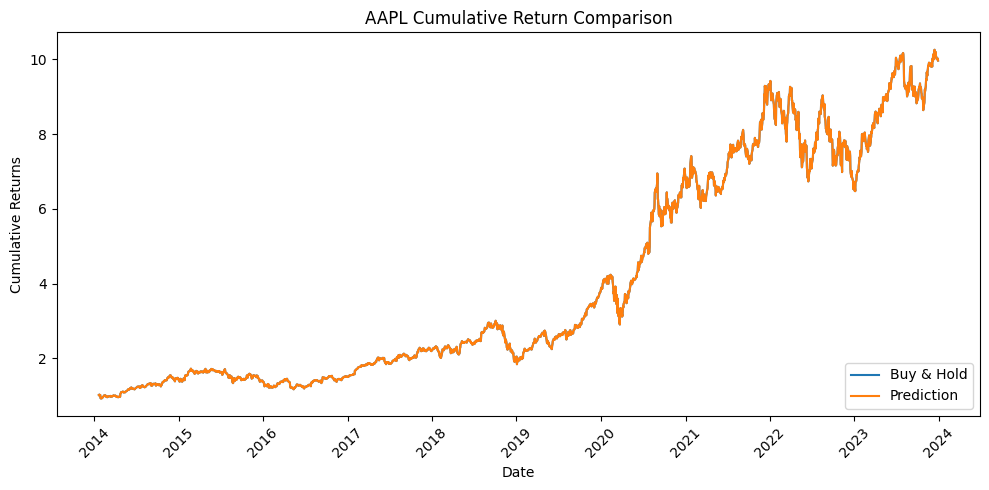

overall results:
0.003858641983320186
Downside deviation list: [0.009237638155220253, 0.012182029302198196, 0.009568027841508928, 0.006730400374372194, 0.014521880850135432, 0.009292550380890585, 0.01987394460240044, 0.010276023975028126, 0.016009751000240414, 0.008192302484387366]
Cumulative return list: [1.3722418250671118, 0.9164072007838004, 1.2255740171076586, 1.4876511674723234, 0.8599581932090686, 2.03316053932092, 1.6355003905004115, 1.4376776990565392, 0.7138618570251167, 1.4817979653067745]
Overall downside deviation: 0.01221028630284056
Overall cumulative return: 9.970665996036624


Training with 100 hidden units, 2 layers, 5 epochs. 20 sequence length


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_6476\4193870312.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


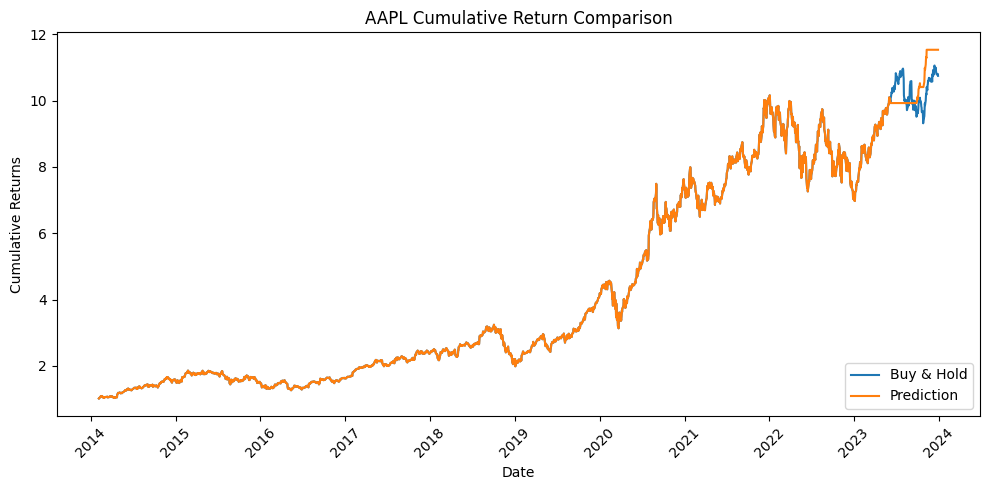

overall results:
0.004464145634158266
Downside deviation list: [0.00800187299119677, 0.012736767062280838, 0.008540424400719147, 0.006776027301664141, 0.014566658017883082, 0.009305710182024496, 0.019948047197206185, 0.010360430154806427, 0.016108132759259167, 0.004572550048532877]
Cumulative return list: [1.635236282141906, 0.8030897353780136, 1.2953555319072327, 1.4525762822099848, 0.8857885973299026, 1.985333387303117, 1.6570951017492757, 1.3561792833243005, 0.7150125829181991, 1.6520487946349196]
Overall downside deviation: 0.01195251697347952
Overall cumulative return: 11.535519256759507


Training with 100 hidden units, 2 layers, 5 epochs. 30 sequence length


C:\Users\Adrian Yau\AppData\Local\Temp\ipykernel_6476\4193870312.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = labels[i+seq_length]


In [16]:
from itertools import product
from sklearn.preprocessing import MinMaxScaler

# Other necessary imports and setup here...

# Define your hyperparameter space
hidden_units_options = [100, 300, 500]
num_layers_options = [ 2, 3,4]
num_epochs_options = [5, 10,20,30]
sequence_length_option = [10,20,30]
# Iterate over all combinations
final_result_df_list = []
for i in tqdm(range(len(all_stock_data_list))):
    filepath = csv_files[i]
    stock = all_stock_data_list[i]
    labels = label_list[i]
    close_pct_change = all_pct_list[i]
    all_date = stock.index
    results = []
    total_rounds = len(hidden_units_options)* len(num_layers_options) *len(num_epochs_options)* len(sequence_length_option)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(stock)
    for hidden_units, num_layers, num_epochs, sequence_length in tqdm(product(hidden_units_options, num_layers_options, num_epochs_options,sequence_length_option),total=total_rounds):
        print(f'Training with {hidden_units} hidden units, {num_layers} layers, {num_epochs} epochs. {sequence_length} sequence length')
        # Call your hyperParameterTuning function or equivalent training procedure
        downside_deviation_list, cumulative_return_list, overall_dd, overall_cr, std_downside_deviation = hyperParameterTuning(hidden_units, num_layers, num_epochs, data_scaled, labels, close_pct_change, all_date, sequence_length)

        # Here you might want to save the results, or print them out
        # For example:
        print(f'Downside deviation list: {downside_deviation_list}')
        print(f'Cumulative return list: {cumulative_return_list}')
        print(f'Overall downside deviation: {overall_dd}')
        print(f'Overall cumulative return: {overall_cr}')

        print('\n')


        result = {
            'hidden_units': hidden_units,
            'num_layers': num_layers,
            'num_epochs': num_epochs,
            'sequence_length': sequence_length,
            'downside_dev_list': downside_deviation_list,
            'cum_ret_list': cumulative_return_list,
            'std_downside_deviation': std_downside_deviation,
            'overall_downside_deviation': overall_dd,
            'overall_cumulative_return': overall_cr
        }
        results.append(result)
    result_df = pd.DataFrame(results)
    final_result_df_list.append(result_df)
    path = result_path +'/'+ csv_files[i].split('\\')[-1][:-4]+ '_result' + '.csv'
    result_df.to_csv(path)
        

